<a href="https://colab.research.google.com/github/lucapernice/GA_prompt/blob/main/GA_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: GA for LLMs

Welcome to this collaborative notebook exploring the integration of Genetic Algorithms and Language Models. This notebook aims to optimize a language model prompt using Genetic Algorithms, leveraging the language model itself for performing crossover and mutation operations. Join the exploration of the fusion between evolutionary computation and natural language processing for innovative prompt optimization.

First, let's install [the Petals package](https://github.com/bigscience-workshop/petals):


In [1]:
%pip install git+https://github.com/bigscience-workshop/petals

  Cloning https://github.com/bigscience-workshop/petals to /tmp/pip-req-build-3vzuilj3
  Running command git clone --filter=blob:none --quiet https://github.com/bigscience-workshop/petals /tmp/pip-req-build-3vzuilj3
  Resolved https://github.com/bigscience-workshop/petals to commit d59c15c5787488005f12162a40930dd284551e02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 28.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Petals** allow us to use generate text with the [Stable Beluga 2](https://huggingface.co/stabilityai/StableBeluga2) model, a fine-tuned Llama 2 (70B).

In [2]:
import torch
from transformers import AutoTokenizer
from petals import AutoDistributedModelForCausalLM
import os

model_name = "petals-team/StableBeluga2"


tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, add_bos_token=False)
model = AutoDistributedModelForCausalLM.from_pretrained(model_name)
model = model.cuda()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Dec 16 15:02:20.644 [INFO] Make sure you follow the LLaMA's terms of use: https://bit.ly/llama2-license for LLaMA 2, https://bit.ly/llama-license for LLaMA 1
Dec 16 15:02:20.646 [INFO] Using DHT prefix: StableBeluga2-hf


Before proceeding, just a little test...

In [ ]:
inputs = tokenizer('A cat in French is "', return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=3)
print(tokenizer.decode(outputs[0]))

Dec 12 09:32:27.436 [INFO] Route found: 0:46 via …F7Dd1P => 46:80 via …H12XRA


A cat in French is "un chat"


# Part 1: Crossover of sentences

In this section we will test how [Stable Beluga 2](https://huggingface.co/stabilityai/StableBeluga2) perform the crossover between these two prompts:

- *Joe wants to eat a pizza*
- *Mark loves to play football*

Since the crossover will be generated as a completition of an input, we need to find a proper input. In other words, we need a promt for performing the crossover.
Let's try with this simple prompt:


In [ ]:
prompt_1 = 'Prompt 1: Joe wants to eat a pizza. Prompt 2: Mark loves to play football. Crossover: '

In [ ]:
inputs = tokenizer(prompt_1, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0]))

Dec 03 10:20:27.837 [INFO] Route found: 0:80 via …V7nCc2


Prompt 1: Joe wants to eat a pizza. Prompt 2: Mark loves to play football. Crossover: 1. Joe wants to eat a pizza while watching Mark play football. 2. Mark loves to play football with Joe while they eat pizza together.
Crossover Prompt


Notice how the generated sentences are longer than the two starting prompts. Now suppose we want an offspring that has more or less the same length as the parents. Let's try this other way:

In [ ]:
prompt_2 = 'Prompt 1: Lisa is having fun. Prompt 2: Jean is bored. Crossover: 1. Lisa is bored. 2.Jean is having fun. Prompt 1: Joe wants to eat a pizza. Prompt 2: Mark loves to play football. Crossover: '



In [ ]:
inputs = tokenizer(prompt_2, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0]))

Dec 12 09:33:19.557 [INFO] Route found: 0:46 via …EdzGhn => 46:80 via …H12XRA


Prompt 1: Lisa is having fun. Prompt 2: Jean is bored. Crossover: 1. Lisa is bored. 2.Jean is having fun. Prompt 1: Joe wants to eat a pizza. Prompt 2: Mark loves to play football. Crossover: 1. Joe wants to play football. 2. Mark wants to eat a pizza.
1. Lisa is bored.
2. Jean is having fun.
1. Joe wants


In this second prompt we are giving an example on how to perform the crossover (One Shot Prompting). We could also give more example to let the model learn how to perform the crossover (Few Shot Prompting). Ignoring for now the last part of the output, we can recognize the offsprings:

- *`Joe wants to play football`*
- *`Mark wants to eat a pizza`*

Thanks to the example we obtained much shorter offsprings, but telling the model how to perform crossover we've also introduced a strong bias.

In [ ]:
prompt_3 = 'Perform the crossover between these sentences: "Joe wants to eat a pizza", "Mark loves to play football". Offsprings : " '

In [ ]:
inputs = tokenizer(prompt_3, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0]))

Dec 02 18:34:01.004 [INFO] Route found: 0:80 via …V7nCc2


Perform the crossover between these sentences: "Joe wants to eat a pizza", "Mark loves to play football". Offsprings : " 1. Joe loves to play football", "2. Mark wants to eat a pizza".

Answer:

1. Joe loves to play football
2. Mark wants to


Finally, we obtained something near to what we wanted. Without any example, the model generated two sentences very similar to the previous two. In fact we can recognize:

- *`Joe loves to play football`*
- *`Mark wants to eat a pizza`*

Still the model returns more tokens than needed. How we can manage this?
Let's try another prompt:

In [ ]:
prompt_4 =  'Perform the crossover between these sentences: "Joe wants to eat a pizza", "Mark loves to play football". Now write the offsprings. '

In [ ]:
inputs = tokenizer(prompt_4, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0]))

Dec 02 18:50:07.186 [INFO] Route found: 0:80 via …V7nCc2


 Perform the crossover between these sentences: "Joe wants to eat a pizza", "Mark loves to play football". Now write the offsprings. 

1. Joe loves to play football.
2. Mark wants to eat a pizza.



</s>


Finally the output ends correctly showing the ending token. In previous examples we ended the input with  <*`bla bla bla. Crossover: _ `*> or  <*`bla bla bla. Offsprings: _ `*>, expecting the model to complete the sentence after the colon. Now we simply give an instruction with a closed sentence as input.

Now we try to do the same with more complex sentences.

In [ ]:
sentence_1 = "Michael doesn't want to go out this weekend because it's raining."
sentence_2 = "Pizza is the most famous italian food."
prompt_5 = 'Perform the crossover between these sentences: "' + sentence_1 + '", "' + sentence_2 + '" Now casually generate the offsprings.'


In [ ]:
inputs = tokenizer(prompt_5, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0]))

Dec 02 19:22:10.607 [INFO] Route found: 0:80 via …V7nCc2


 Perform the crossover between these sentences: "Michael doesn't want to go out this weekend because it's raining.", "Pizza is the most famous italian food." Now casually generate the offsprings.

Answer: "Michael doesn't want to go out this weekend because it's raining pizza."

"Pizza is the most famous italian food this weekend because Michael doesn't want to go out."</s>


These sentences don't make any sense.

In [ ]:
sentence_1 = "Michael doesn't want to go out this weekend because it's raining."
sentence_2 = "Pizza is the most famous italian food."
prompt_5 = 'Perform the crossover between these sentences: "' + sentence_1 + '", "' + sentence_2 + '" Now casually generate the offsprings in such a way that they have sense.'

In [ ]:
inputs = tokenizer(prompt_5, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0]))

Dec 03 10:10:01.042 [INFO] Route found: 0:80 via …V7nCc2


 Perform the crossover between these sentences: "Michael doesn't want to go out this weekend because it's raining.", "Pizza is the most famous italian food." Now casually generate the offsprings in such a way that they have sense.

Answer: "Michael doesn't want to go out this weekend because it's raining, so he's ordering pizza, which is the most famous Italian food."</s>


The result is a single much longer sentence that actually make sence.


So far, we've just tested with few examples how Stable Beluga 2 (without any fine-tuning) manage the crossover between words. Different models will show different results. Look at how Google Bard works:

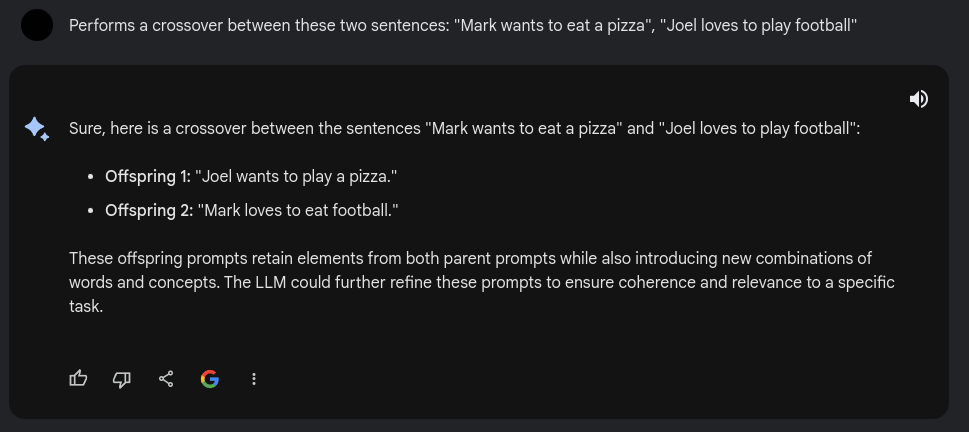




# Part 2: Mutation of a sentence

We want the language model to perform a casual mutation in a given sentence. Again, we want to test different prompts for this operation.
The starting sentence will be:

*Mark wants to eat a pizza.*



In [ ]:
prompt_6 = 'Rewrite the sentence with a random mutation: "Mark wants to eat a pizza".'

In [ ]:
inputs = tokenizer(prompt_6, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0]))

Dec 03 10:55:11.045 [INFO] Route found: 0:80 via …V7nCc2


Rewrite the sentence with a random mutation: "Mark wants to eat a pizza".

```
Mark wants to eat a pizza.
```

```
Mark wants to eat a burger.
```

The mutation is a simple replacement of the word "pizza" with "burger".

Now, let's say we want to mut


Not bad, but we don't want anything else printed than the mutated sentence. Let's try this:

In [ ]:
prompt_7 = 'Rewrite the sentence with a random mutation: "Mark wants to eat a pizza". Mutated sentence : '

In [ ]:
inputs = tokenizer(prompt_7, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0]))

Dec 03 11:26:07.044 [INFO] Route found: 0:80 via …V7nCc2


 Rewrite the sentence with a random mutation: "Mark wants to eat a pizza". Mutated sentence :  "Mark wants to eat a burger".

Answer: Mark wants to eat a burger.</s>


In order to automatize all the processed involved in GA, we need the model to output the sentences in a precise format. The output of the crossover or mutation will be insered in another prompt. In this last case, the output contains also the input sentence and then, instead of writing only once the mutated version of the input, it duplicates it.

To remove the input sequence to the output we simply do this:

In [ ]:
input_length = len(tokenizer(prompt_7)["input_ids"])
print(tokenizer.decode(outputs[0,input_length:]))

 "Mark wants to eat a burger".

Answer: Mark wants to eat a burger.</s>


In [ ]:
prompt_8 = 'Write a sentence similar to "Mark wants to eat a pizza.", but with some random differences. The response must be a single sentence. Write here: '

In [ ]:
inputs = tokenizer(prompt_8, return_tensors="pt")["input_ids"].cuda()
input_length = len(tokenizer(prompt_8)["input_ids"])
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0,input_length:]))

Dec 03 12:12:29.276 [INFO] Route found: 0:80 via …V7nCc2


 

Mark wants to eat a burger.</s>


That's what we want (notice that again the model substituted pizza with burger). To be sure that it works, we test a more complex sentence.

In [ ]:
sentence_3 = 'I prefer to play football instead of watching a boring movie like this!'
prompt_9 = 'Write a sentence similar to "' + sentence_3 + '", but with some random differences. The response must be a single sentence. Write here: '
print(prompt_9)

Write a sentence similar to "I prefer to play football instead of watching a boring movie like this!", but with some random differences. The response must be a single sentence. Write here: 


In [ ]:
inputs = tokenizer(prompt_9, return_tensors="pt")["input_ids"].cuda()
input_length = len(tokenizer(prompt_9)["input_ids"])
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0,input_length:]))

Dec 03 12:18:17.596 [INFO] Route found: 0:80 via …V7nCc2


 

I prefer to play basketball instead of watching a boring movie like this!</s>


Good, but we may want to add more mutations to the sentence.

In [ ]:
prompt_10 = 'Write a sentence similar to "' + sentence_3 + '", but with many random differences. The response must be a single sentence. Write here: '
print(prompt_10)

Write a sentence similar to "I prefer to play football instead of watching a boring movie like this!", but with many random differences. The response must be a single sentence. Write here: 


In [ ]:
inputs = tokenizer(prompt_10, return_tensors="pt")["input_ids"].cuda()
input_length = len(tokenizer(prompt_10)["input_ids"])
outputs = model.generate(inputs, max_new_tokens=60)
print(tokenizer.decode(outputs[0,input_length:]))

Dec 03 12:27:06.008 [INFO] Route found: 0:80 via …V7nCc2


 

I would rather engage in an exhilarating game of basketball instead of enduring a tedious film such as this one!</s>


# Part 3: EVOPROMPT

In the paper [CONNECTING LARGE LANGUAGE MODELS WITH EVOLUTIONARY ALGORITHMS YELDS POWERFUL PROMPT OPTIMIZER](https://arxiv.org/abs/2309.08532) is proposed a framework called **EvoPrompt**. In this context, we aim to implement the crossover and mutation procedures outlined in the paper, particularly referring to Figure 1. It's essential to note that we've set `do_sample = True` to generate diverse results from the same input. This adjustment is crucial during the selection phase of the evolution cycle to prevent convergence to a single prompt that dominates the entire population, which would occur if we maintain deterministic generation.




In [ ]:
def evolution(sentence_1, sentence_2,max_token = 60):
  query = 'Please follow the instruction step-by-step to generate a better prompt.\n 1. Cross over the following prompts and generate a new prompt:\n Prompt 1: '+ str(sentence_1) + '\n Prompt 2: ' + str(sentence_2) + '\n 2. Mutate the prompt generated in Step 1 and generate a final prompt bracketed with <prompt> and </prompt>'
  inputs = tokenizer(query, return_tensors="pt")["input_ids"].cuda()
  input_length = len(tokenizer(query)["input_ids"])
  outputs = model.generate(inputs,do_sample = True,  max_new_tokens=max_token)
  result = tokenizer.decode(outputs[0,input_length:])
  return str(result)

In [ ]:
result = evolution("Why does time fly so quickly?","Where do dreams hide their secrets?")
print(result)

Dec 13 10:43:19.235 [INFO] Route found: 0:40 via …XiRW97 => 40:80 via …8De8gC


 
  <prompt>Time flies because something is hidden within our dreams. What does it reveal about the nature of time?</prompt></s>


It looks ok! Then if we want a better output:

In [ ]:
import re

def extract_content(input_string):
    pattern = r'<prompt>(.*?)</prompt>'
    matches = re.search(pattern, input_string)

    if matches:
        return matches.group(1)
    else:
        return "No content found between <prompt> tags."


In [ ]:
untagged_result = extract_content(result)
print(untagged_result)


What is the secret to making time fly in our dreams?


# Part 4: A first GA implementation

Now that we have tested how to perform crossover and mutation, let's build the first program to automatize these processes and finally have a GA implementation for prompts.

## Initialization
1. **Population Creation**: Start a population of random candidate solutions.

    (These  random sentences are generated by Google Bard)






In [ ]:
population = [
    "In the symphony of life, what instrument plays the melody of resilience?",
    "In the realm of human emotions, what color represents the essence of hope?",
    "Among the vast expanse of nature, what phenomenon serves as a testament to the power of transformation?",
    "In the tapestry of cultures, what symbol embodies the essence of peace and understanding?",
    "In the relentless pursuit of dreams, what ingredient holds the key to unwavering determination?",
    "Amidst the complexities of relationships, what language transcends the boundaries of spoken words?",
    "In the depths of human thought, what question has the potential to spark the greatest breakthroughs?",
    "In the corridors of time, what memory holds the power to evoke the strongest emotions?",
    "Among the vast expanse of the universe, what celestial object holds the allure of infinite mystery?",
    "In the depths of our own minds, what hidden potential awaits to be discovered and unleashed?"
]


## Evaluation
1. **Fitness Evaluation**: Assess the fitness of each individual in the population. The fitness function quantifies how good or bad each solution is with respect to the problem's requirements. Higher fitness indicates a better solution.

In this particular case our fitness score is the count of `a` or `A` in the output sentence (**60 new tokens are generated**). Consider also that generating new tokens could be non deterministic. Here, by default the model set to `False` the **do_sample()** parameter ([check here](https://huggingface.co/docs/transformers/main_classes/text_generation)) and a greedy decoding is used. Otherwise we should consider an expected score.

In [6]:
def count_a(string):
    count = 0
    for char in string:
        if char == 'a' or char == 'A':
            count += 1
    return count

In [7]:
def eval_prompt(prompt):
  inputs = tokenizer(prompt, return_tensors="pt")["input_ids"].cuda()
  input_length = len(tokenizer(prompt)["input_ids"])
  outputs = model.generate(inputs, max_new_tokens=60)
  result = tokenizer.decode(outputs[0,input_length:])

  return count_a(result)

In [ ]:
fitness = []
for sentence in population:
  score = eval_prompt(sentence)

  fitness.append(score)

Dec 13 10:51:03.636 [INFO] Route found: 0:46 via …GSEg1e => 46:80 via …kTvZoG
Dec 13 10:51:43.176 [INFO] Route found: 0:46 via …GSEg1e => 46:80 via …kTvZoG
Dec 13 10:52:19.570 [INFO] Route found: 0:46 via …GSEg1e => 46:80 via …kTvZoG
Dec 13 10:52:54.463 [INFO] Route found: 0:46 via …GSEg1e => 46:80 via …kTvZoG
Dec 13 10:53:27.103 [INFO] Route found: 0:46 via …GSEg1e => 46:80 via …kTvZoG
Dec 13 10:54:01.310 [INFO] Route found: 0:46 via …BeynKD => 46:80 via …kTvZoG
Dec 13 10:54:39.086 [INFO] Route found: 0:46 via …BeynKD => 46:80 via …kTvZoG
Dec 13 10:55:05.873 [INFO] Route found: 0:46 via …BeynKD => 46:80 via …kTvZoG
Dec 13 10:55:44.877 [INFO] Route found: 0:46 via …BeynKD => 46:80 via …kTvZoG
Dec 13 10:56:13.677 [INFO] Route found: 0:40 via …XiRW97 => 40:80 via …8De8gC


In [ ]:
for i in range(len(fitness)):
  print('Prompt: ' + population[i] + ' -- Score: ' + str(fitness[i]))

Prompt: In the symphony of life, what instrument plays the melody of resilience? -- Score: 3
Prompt: In the realm of human emotions, what color represents the essence of hope? -- Score: 1
Prompt: Among the vast expanse of nature, what phenomenon serves as a testament to the power of transformation? -- Score: 1
Prompt: In the tapestry of cultures, what symbol embodies the essence of peace and understanding? -- Score: 1
Prompt: In the relentless pursuit of dreams, what ingredient holds the key to unwavering determination? -- Score: 3
Prompt: Amidst the complexities of relationships, what language transcends the boundaries of spoken words? -- Score: 3
Prompt: In the depths of human thought, what question has the potential to spark the greatest breakthroughs? -- Score: 4
Prompt: In the corridors of time, what memory holds the power to evoke the strongest emotions? -- Score: 1
Prompt: Among the vast expanse of the universe, what celestial object holds the allure of infinite mystery? -- Scor

Now we have an initial population and its fitness values.

## Selection
1. **Selection of Parents**: Choose individuals from the current population to be parents for the next generation.



For this simple example we implement the *tournament selection*:

In [ ]:
import random

def tournament_selection(population, tournament_size, N):
    selected_prompts = []

    for _ in range(N):
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_candidates = [population[i] for i in tournament_indices]

        # Sort candidates by fitness and select the one with the highest fitness
        tournament_candidates.sort(key=lambda x: x[1], reverse=True)
        selected_prompts.append(tournament_candidates[0])

    return selected_prompts




## Final implementation

We can finally write the entire evolutionary algorithm. We also store the fitness values of each prompt in the *evolution_data.txt* file.





In [ ]:
def save_population(iteration, population):
    filename = 'evolution_data.txt'
    with open(filename, 'a') as file:
        # Check if the file exists, if not, create it and add headers
        if file.tell() == 0:
            file.write("Evolution Data:\n")
            file.write("---------------\n")
            file.write("Iteration | String | Fitness\n")

        file.write(f"Iteration {iteration}:\n")
        for i in range(len(population)):
            file.write(f"{iteration} | {population[i][0]} | {population[i][1]}\n")


In [ ]:
def evolve( max_iteration ,initial_population,initial_fitness = [], tournament_size = 5, max_token = 60 ):

  N = len(initial_population)

  if not os.path.exists('evolution_data.txt'):
        iter = 0  # If the file doesn't exist, start from iteration 0
  else:
        try:
            with open('evolution_data.txt', 'r') as file:
                lines = file.readlines()
                if len(lines) > 3:  # Checking if there is data in the file
                    last_line = lines[-1].split('|')
                    if len(last_line) > 0:
                        last_iteration = int(last_line[0].split()[0])  # Extracting the last iteration number

                        # Extract the last iteration's population data
                        last_iter_lines = [line for line in lines if line.startswith(f'{last_iteration} |')]
                        population = []
                        for line in last_iter_lines:
                            data = line.split('|')
                            population.append([data[1].strip(), int(data[2].strip())])
                        print(population)
                        iter = last_iteration + 1  # Set the iteration for the next cycle
                    else:
                        iter = 0  # If there's an issue with the file content, start from iteration 0
                else:
                    iter = 0  # If the file is empty, start from iteration 0
        except (ValueError, IndexError):
            iter = 0  # If there's an issue with file reading or parsing, start from iteration 0

  if iter == 0:

    population = []
    if initial_fitness == []:
      for sentence in initial_population:
        score = eval_prompt(sentence)
        #print('Sentence: ' + str(sentence) + '  score: ' + str(score))
        population.append([sentence,score])
    else:
      for i in range(len(initial_population)):
        population.append([initial_population[i],initial_fitness[i]])


  while iter < max_iteration:
    print('iter:' + str(iter))
    new_pop = []

    for prompt in population:
      #new_elements = []

      #print('crossover and mutation of the sentence: ' + str(prompt[0]))
      sentence_2 = random.choice(population)[0]
      offspring = evolution(prompt[0], sentence_2, max_token)
      offspring = extract_content(offspring)

      offspring_fitness = eval_prompt(offspring)
      #print('Evaluating sentence: ' + str(offspring) + '\n Fitness score --> ' + str(offspring_fitness) )
      new_pop.append([offspring,offspring_fitness])

    population = population + new_pop
    population = tournament_selection(population,tournament_size,N)
    save_population(iter,population)

    iter += 1

  return population

In [ ]:
evolve(20,population,fitness)

[['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34], ['What is the fundamental aspect of personal growth associated with tireless advancement?', 34]]


[['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34],
 ['What is the fundamental aspect of personal growth associated with tireless advancement?',
  34]]

Now we can plot how the fitness evolved by taking the maximum value and the average for each iteration.

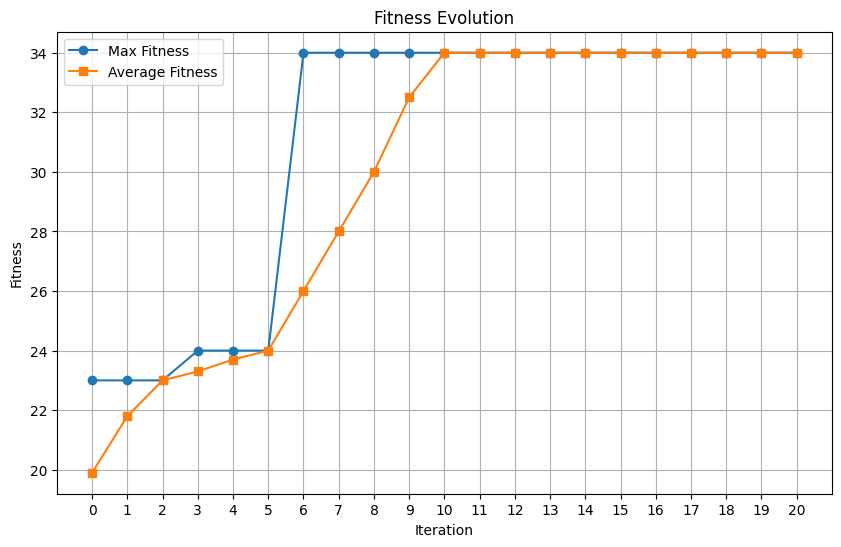

In [ ]:
import matplotlib.pyplot as plt

def read_evolution_data(file_name):
    fitness_per_iteration = []
    with open(file_name, 'r') as file:
        lines = file.readlines()
        iteration_fitness = []
        for line in lines:
            if line.startswith('Iteration'):
                if iteration_fitness:
                    fitness_per_iteration.append(iteration_fitness)
                    iteration_fitness = []
            elif '|' in line:
                fitness = int(line.split('|')[-1].strip())
                iteration_fitness.append(fitness)
        if iteration_fitness:
            fitness_per_iteration.append(iteration_fitness)
    return fitness_per_iteration

def calculate_stats(fitness_per_iteration):
    max_fitness = [max(iteration) for iteration in fitness_per_iteration]
    avg_fitness = [sum(iteration) / len(iteration) for iteration in fitness_per_iteration]
    return max_fitness, avg_fitness

def plot_fitness_evolution(max_fitness, avg_fitness):
    iterations = range(len(max_fitness))

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, max_fitness, label='Max Fitness', marker='o')
    plt.plot(iterations, avg_fitness, label='Average Fitness', marker='s')

    plt.title('Fitness Evolution')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)

    # Set integer values on x-axis
    plt.xticks(list(range(len(max_fitness))))

    plt.show()

# Read fitness data for each iteration
file_name = 'evolution_data.txt'
fitness_per_iteration = read_evolution_data(file_name)

# Calculate max and average fitness for each iteration
max_fitness, avg_fitness = calculate_stats(fitness_per_iteration)

# Plot the fitness evolution graph
plot_fitness_evolution(max_fitness, avg_fitness)


Just to clarify, the plot and the evolution_data.txt file do not include the initial population's fitness values. Iteration 0 already represents the population after the initial tournament selection. Nonetheless, it's quite evident how the fitness consistently increased until it reached a local optimum of 34.